In [7]:
import gdal, osr
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [73]:
from matplotlib.colors import ListedColormap

In [64]:
def raster2array(rasterfn):
    #print('converting raster to array...')
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array

In [3]:
ecoCost = raster2array(os.path.abspath('01_Data500/fac_eco_onlySlope.tif'))
envCost = raster2array(os.path.abspath('01_Data500/fac_env.tif'))
infCost = raster2array(os.path.abspath('01_Data500/fac_inf.tif'))
pubCost = raster2array(os.path.abspath('01_Data500/fac_pub.tif'))
allCost = (ecoCost+envCost+infCost+pubCost)/4

converting raster to array...
converting raster to array...
converting raster to array...
converting raster to array...


## Select DC and path_based_on

In [9]:
dc ='dc5'
path_based_on = 'all'
pathFile = os.path.abspath('01_Data500/out')+'\\'+path_based_on+'_'+dc+'.tif'

In [42]:
factors = ['eco','env','inf','pub', 'all']

In [54]:
lines = ['dc1','dc2','dc3','dc4','dc5']

In [61]:
def line_path(path_based_on, dc):
    pathFl =  os.path.abspath('01_Data500/out')+'\\'+path_based_on+'_'+dc+'.tif'
    return raster2array(pathFl)

In [74]:
colors = ['blue','green','firebrick', 'm','gray']
cmap = ListedColormap(colors)

# Line Length

In [65]:
def lineLength(lineArray):
    indicies = np.nonzero(lineArray)
    indicies_paired = np.stack((indicies[0],indicies[1]), axis=-1)
    disTot = 0
    for point in range(1,len(indicies_paired)-1,1):
        x1 = indicies_paired[point-1][0]
        y1 = indicies_paired[point-1][1]
        x2 = indicies_paired[point][0]
        y2 = indicies_paired[point][1]
        dist = np.sqrt((x2-x1)**2+(y2-y1)**2)
        disTot = disTot+dist
    return disTot

In [66]:
allLineLenghts = []
for line in lines:
    for factor in factors:
        print(line, factor)
        lineLen = lineLength(line_path(path_based_on=factor, dc=line))
        allLineLenghts.append([line, factor, lineLen])
lengths = pd.DataFrame(allLineLenghts)
lengths.columns=['dc','basedOn','length']

dc1 eco
dc1 env
dc1 inf
dc1 pub
dc1 all
dc2 eco
dc2 env
dc2 inf
dc2 pub
dc2 all
dc3 eco
dc3 env
dc3 inf
dc3 pub
dc3 all
dc4 eco
dc4 env
dc4 inf
dc4 pub
dc4 all
dc5 eco
dc5 env
dc5 inf
dc5 pub
dc5 all


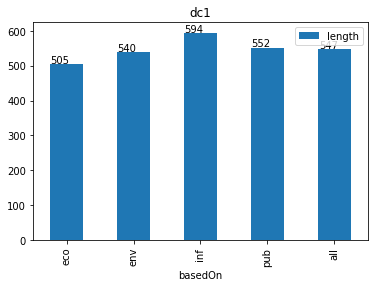

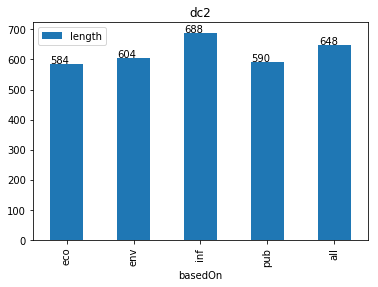

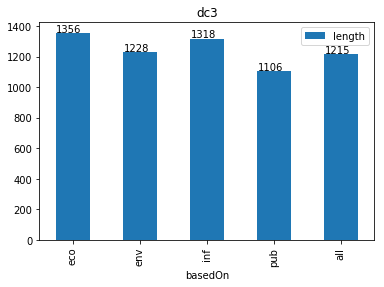

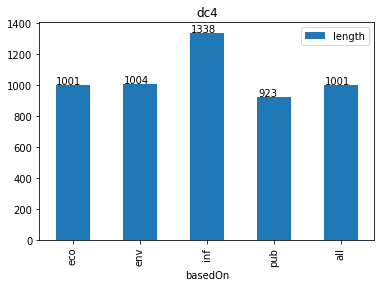

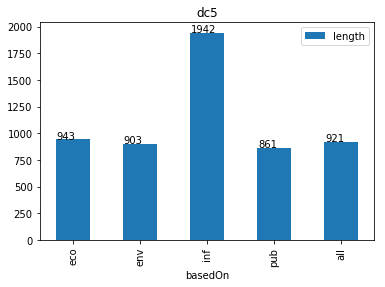

In [80]:
for line in lines:
    dcLine = lengths.loc[lengths['dc']==line]
    ax = dcLine.set_index('basedOn').plot(kind='bar', title=line)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()

# Population effected

In [81]:
popu = raster2array(os.path.abspath('01_Data500/population.tif'))

In [84]:
def peopleEffected(line, basedOn):
    path = line_path(path_based_on=basedOn, dc = line)
    return np.multiply(popu,path).sum()

In [85]:
peopleEffectedAll = []
for line in lines:
    for factor in factors:
        print(line, factor)
        peopleEff = peopleEffected(line, factor)
        peopleEffectedAll.append([line,factor, peopleEff])

peopleEff = pd.DataFrame(peopleEffectedAll)
peopleEff.columns=['dc','basedOn','peopleEffected']

dc1 eco
dc1 env
dc1 inf
dc1 pub
dc1 all
dc2 eco
dc2 env
dc2 inf
dc2 pub
dc2 all
dc3 eco
dc3 env
dc3 inf
dc3 pub
dc3 all
dc4 eco
dc4 env
dc4 inf
dc4 pub
dc4 all
dc5 eco
dc5 env
dc5 inf
dc5 pub
dc5 all


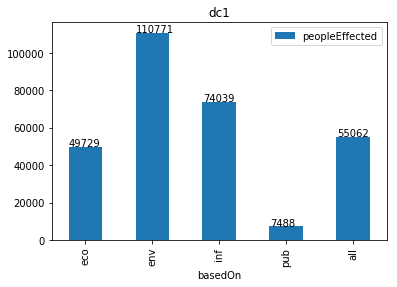

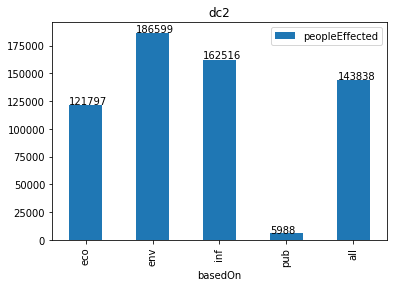

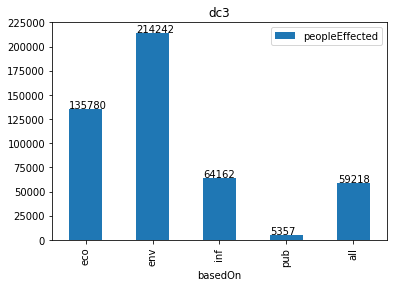

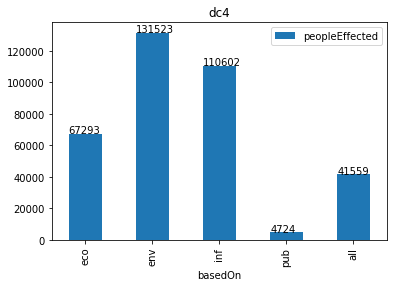

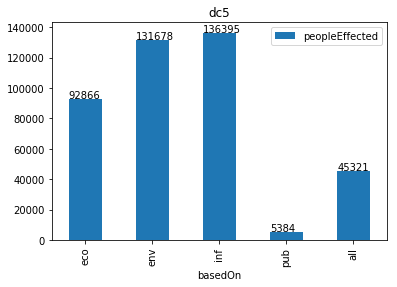

In [88]:
for line in lines:
    dcLine = peopleEff.loc[lengths['dc']==line]
    ax = dcLine.set_index('basedOn').plot(kind='bar', title=line)
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()

In [22]:
def getCosts(path_based_on, dc):
    linePath = line_path(path_based_on=path_based_on, dc = dc)
    ecoCostLine = np.multiply(ecoCost, linePath).sum()
    envCostLine = np.multiply(envCost, linePath).sum()
    infCostLine = np.multiply(infCost, linePath).sum()
    pubCostLine = np.multiply(pubCost, linePath).sum()
    allCostLine = np.multiply(allCost, linePath).sum()
    return [ecoCostLine, envCostLine, infCostLine, pubCostLine, allCostLine]

In [120]:
def allCosts(line):
    cost = []
    for factor in factors:
        print(factor)
        facCost = getCosts(path_based_on=factor, dc=line)
        cost.append(facCost)
    allCost = pd.DataFrame(cost)
    allCost.columns=['eco','env','inf','pub','all']
    allCost['path_on'] = ['p_eco','p_env','p_inf','p_pub','p_all']
    return allCost.set_index('path_on')


In [121]:
dc5 = allCosts('dc5')

eco
converting raster to array...
env
converting raster to array...
inf
converting raster to array...
pub
converting raster to array...
all
converting raster to array...


In [125]:
dc3 = allCosts('dc3')

eco
converting raster to array...
env
converting raster to array...
inf
converting raster to array...
pub
converting raster to array...
all
converting raster to array...


In [127]:
dc4 = allCosts('dc4')

eco
converting raster to array...
env
converting raster to array...
inf
converting raster to array...
pub
converting raster to array...
all
converting raster to array...


In [186]:
def costGraph(data, title):
    data.plot(kind='bar',cmap=cmap)
    plt.title(title)
    plt.show()
    

def costDiffGraph(data, title):
    data.sub(data.xs('p_all'),axis=1).plot(kind='bar',cmap=cmap)
    plt.title(title)
    plt.show()
    
def costDiffNormGraph(data, title):
    data.sub(data.xs('p_all'), axis=1).div(data.xs('p_all'),axis=1).plot(kind='bar', cmap=cmap)
    plt.title(title)
    plt.show()

In [193]:
dc3[dc3.columns!='all']

,eco,env,inf,pub,all
path_on,,,,,
p_eco,141.790726,407.788910,1003.851562,262.999634,454.109680
p_env,209.463242,250.187866,1003.522034,244.799637,426.995270
p_inf,237.831360,373.253052,626.665405,165.900391,350.913818
p_pub,238.517914,389.121155,995.272156,105.898956,432.205353


In [189]:
dc3.sum(axis=1)

path_on
p_eco    2270.540512
p_env    2134.968048
p_inf    1754.564026
p_pub    2161.015533
p_all    1722.999115
dtype: float64

In [190]:
dc4.sum(axis=1)

path_on
p_eco    1797.233978
p_env    1711.903397
p_inf    1580.111588
p_pub    1849.490990
p_all    1436.196419
dtype: float64

In [191]:
dc5.sum(axis=1)

path_on
p_eco    1667.273041
p_env    1593.407990
p_inf    1460.740982
p_pub    1713.110092
p_all    1368.688736
dtype: float64

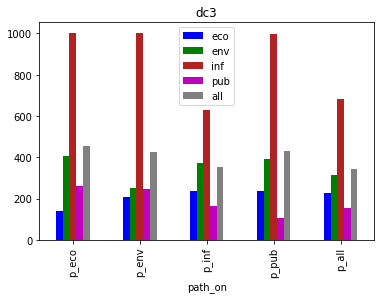

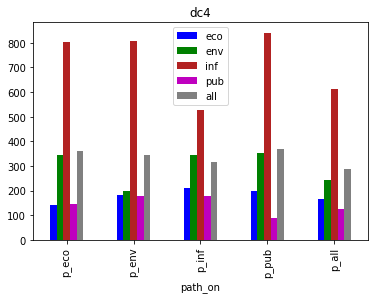

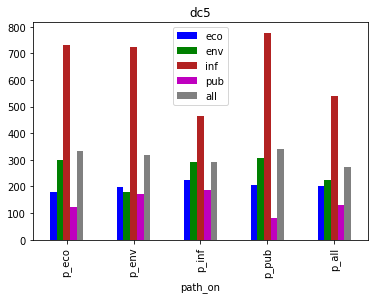

In [183]:
costGraph(dc3, 'dc3')
costGraph(dc4, 'dc4')
costGraph(dc5, 'dc5')

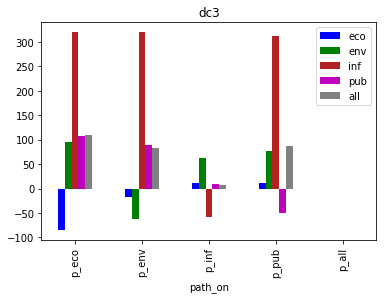

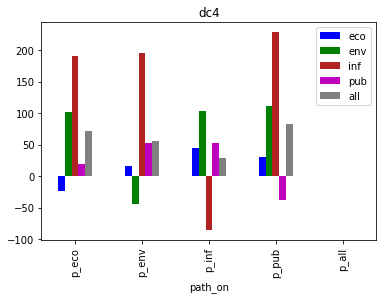

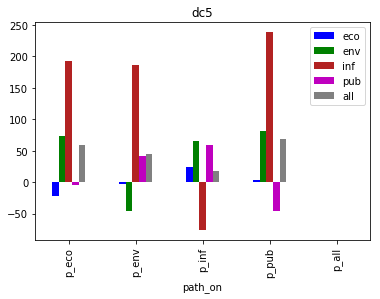

In [184]:
costDiffGraph(dc3, 'dc3')
costDiffGraph(dc4, 'dc4')
costDiffGraph(dc5, 'dc5')

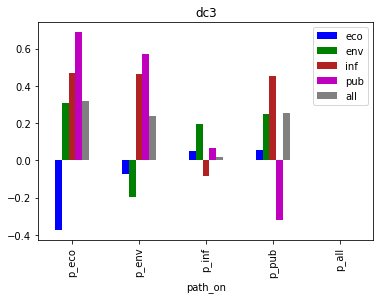

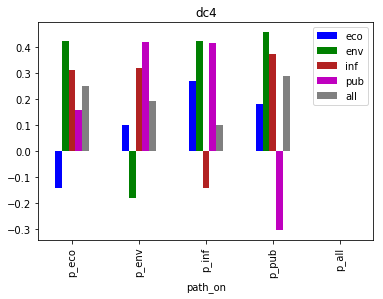

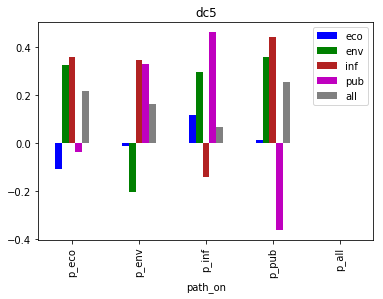

In [187]:
costDiffNormGraph(dc3, 'dc3')
costDiffNormGraph(dc4, 'dc4')
costDiffNormGraph(dc5, 'dc5')